### MEDATech TMS Modelling

#### Basic TMS loop considered in analysis
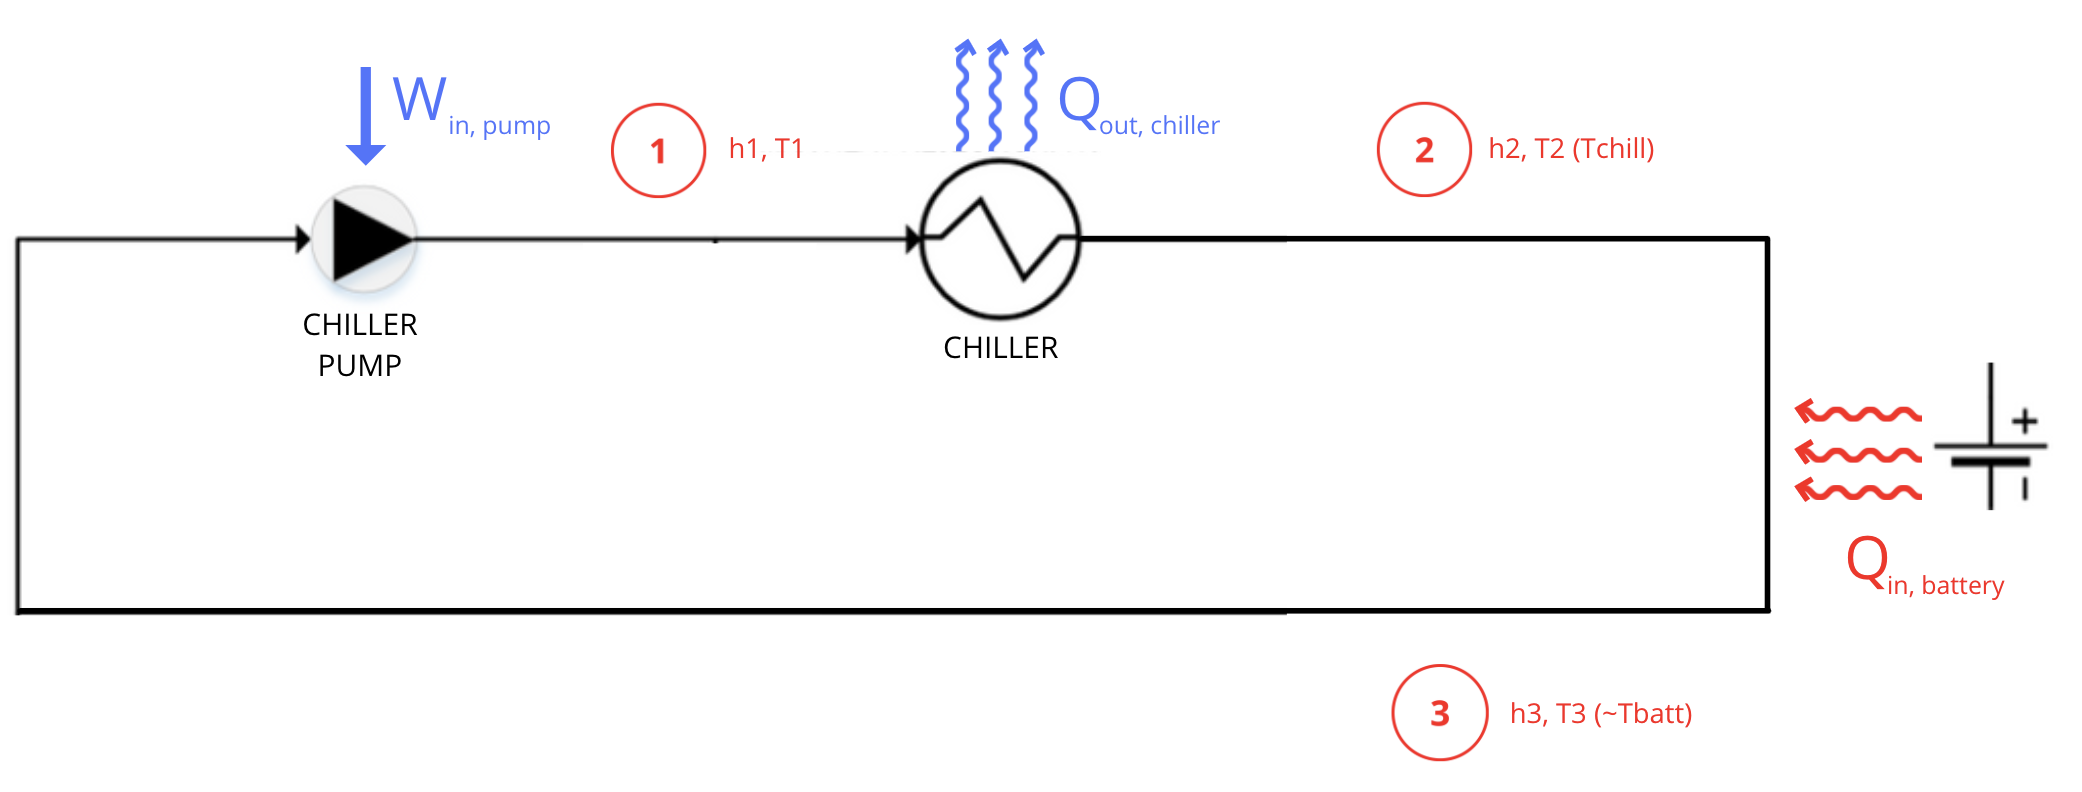

In [5]:
## [IMPORTANT] RUN THIS PROGRAM USING THE PYTHON 3.7.4 64-BIT KERNEL

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import integrate
from matplotlib.pyplot import figure

ModuleNotFoundError: No module named 'scipy'

In [3]:
def getParams(VFR,chiller_capacity,loadCase):  
    if loadCase == "WP":
        filenames = ["W51335_Duty_w_Payload_05C.txt","W51335_Duty_w_Payload_15C.txt",\
                     "W51335_Duty_w_Payload_25C.txt","W51335_Duty_w_Payload_35C.txt"]
    if loadCase == "NP":
        filenames = ["W51335_Duty_no_Payload_05C.txt","W51335_Duty_no_Payload_15C.txt",\
                 "W51335_Duty_no_Payload_25C.txt","W51335_Duty_no_Payload_35C.txt"]
    t = []
    Qin_batt = []
    Tbatt = []
    VFR_WEG = VFR/60000 # [m^3/s] volumetric flow rate used in drive cycle, converted from L/min
    mdot_WEG = []
    Cp_WEG = []
    Tcool_needed=[]
    Tcool_provided=[]
    Qout_chiller = chiller_capacity # [W]
    
    def interpolate(x,x2,x1,y2,y1):
        y = (x-x1)*(y2-y1)/(x2-x1)+y1
        return y
    
    for i in range(len(filenames)):
        # Import drive cycle data
        A=np.loadtxt(filenames[i]) # load drive cycle data
        t_i=A[:,0] # [s] elapsed drive cycle time
        Qin_batt_i=A[:,1] # [W] heat output of batteries at each time measurement (between states 3 and 1)
        Tbatt_i=A[:,2] # [ºC] temp. of battery at each time measurement     
        
        if filenames[i][-7:-5] == '05': # 5ºC drive cycle
            Cp_WEG_i=interpolate(5,10,0,3442,3412) # [J/kgºC] specific heat, assumed const. @ ambient temp
            rho_WEG_i=interpolate(5,20,0,1079,1092) # [kg/m^3] density, assumed const. @ ambient temp
        elif filenames[i][-7:-5] == '15': # 15ºC drive cycle
            Cp_WEG_i=interpolate(15,20,10,3473,3442)
            rho_WEG_i=interpolate(15,20,0,1079,1092)
        elif filenames[i][-7:-5] == '25': # 25ºC drive cycle
            Cp_WEG_i=interpolate(25,30,20,3504,3473)
            rho_WEG_i=interpolate(25,40,20,1067,1079)
        elif filenames[i][-7:-5] == '35': # 35ºC drive cycle
            Cp_WEG_i=interpolate(35,40,30,3534,3504)
            rho_WEG_i=interpolate(35,40,20,1067,1079)
        
        mdot_WEG_i = rho_WEG_i*VFR_WEG  # [kg/s] mass flow rate of coolant, assumed const. @ ambient temp
        
        Tcool_needed_i = []
        for j in range(len(t_i)):
            Tcool_needed_i.append(Tbatt_i[j]-Qin_batt_i[j]/(Cp_WEG_i*mdot_WEG_i))
        
        Tcool_provided_i = []
        for j in range(len(t_i)):
            Tcool_provided_i.append(Tbatt_i[j]-Qout_chiller/(Cp_WEG_i*mdot_WEG_i))          
        
        t.append(t_i)
        Qin_batt.append(Qin_batt_i)
        Tbatt.append(Tbatt_i)
        Cp_WEG.append(Cp_WEG_i)
        mdot_WEG.append(mdot_WEG_i)
        Tcool_needed.append(Tcool_needed_i)
        Tcool_provided.append(Tcool_provided_i)
    
    return t, Qin_batt, Tbatt, Tcool_needed, Tcool_provided

In [4]:
def getAvgParams(params): # takes average values of all 4 drive cycles at each timestep
    avgParams = [] # 1x5 list of drive-cycle-averaged values for ALL parameters returned from getParams() at each timestep
    for i in range(len(params)):
        avg_i = [] # 1x4000 (e.g.) list of drive-cycle-averaged values for ONE parameter (e.g. Tbatt) at each timestep
        for j in range(len(params[i][1])): # find avg value across all four drive cycles at each step in time
            vals = []
            for k in range(len(params[i])):
                vals.append(params[i][k][j])
            avg_ij = sum(vals)/4
            avg_i.append(avg_ij)
        avgParams.append(avg_i)
    return avgParams

In [5]:
# Finds the temp difference between the Tcool needed to reject 100% of the battery heat generation,
# and the Tcool that can be provided by a given chiller. Lower gap magnitudes are preferable from
# a TMS perspective
def getTempGap(avgParams):
    Tcool_needed = avgParams[3]
    Tcool_provided = avgParams[4]
    tempGap = []

    for a, b in zip(Tcool_needed, Tcool_provided):
        tempGap.append(a-b)
        
    return tempGap

In [6]:
# Computes the total area between Tcool_needed and Tcool_provided for the entire drive
# cycle. Smaller tempGapIntegral magnitudes are preferable from a TMS perspective,
# with tempGapIntegral=0 being optimal.

def getTempGapIntegral(VFR,chiller_options,loadCase):
    tempGapIntegrals = []
    for i in range(len(chiller_options)):
        params = getParams(VFR,chiller_options[i],loadCase) # [1x5 of [1x4 of [1x~4000]]]
        avgParams = getAvgParams(params) # [1x5 of [1x~4000]]
        tempGap = getTempGap(avgParams)
        tempGapIntegral = integrate.cumtrapz(tempGap, avgParams[0], initial=tempGap[0])[-1]
        tempGapIntegrals.append(tempGapIntegral)
    return tempGapIntegrals

In [7]:
# The optimum chiller capacity is that at which the tempGapIntegral becomes equal 
# to zero.
def getIdealCapacity(VFR,chiller_options,loadCase):
    tempGapIntegrals = getTempGapIntegral(VFR,chiller_options,loadCase)
    S = scipy.interpolate.interp1d(chiller_options,tempGapIntegrals, kind='linear')
    xx = np.linspace(min(chiller_options),max(chiller_options),100000)
    yy = S(xx)
    tol=1 #tolerance of index search (± 1ºC)
    idealIdx=np.where((yy >0-tol) & (yy<0+tol))[0][0]
    idealCapacity=xx[idealIdx]
    return idealCapacity

In [8]:
# Generates plots @ constant flow rate and chiller capacity
def plotter1(VFR,chiller_capacity,loadCase): 
    params = getParams(VFR,chiller_capacity,loadCase) # [1x5 of [1x4 of [1x~4000]]]
    avgParams = getAvgParams(params) # [1x5 of [1x~4000]]
    
    if loadCase == "WP":
        label1 = "(w/ payload)"
    elif loadCase == "NP":
        label1 = "(w/out payload)"
        
    labels2 = ['5C','15C','25C','35C']
    figure(dpi=100)
    for i in range(len(params[0])):
        plt.plot(params[0][i],params[2][i],label=labels2[i]) #each index i contains a full list of values for a single drive cycle
        plt.title('Battery temperature vs. time ' + label1,fontsize=12)
        plt.xlabel('Elapsed drive time [s]',fontsize=10)
        plt.ylabel('Battery temperature [ºC]',fontsize=10)
        
        plt.legend(title = 'Drive Cycle',fontsize=8).get_title().set_fontsize(8)
    plt.grid(axis = 'y',color = 'silver', linestyle = '--', linewidth = 0.4)
    plt.savefig('Tbatt_vs_Time_'+loadCase+'.png')
    plt.show()
    
    

In [9]:
# Generates plots @ variable flow rate and constant chiller capacity
def plotter2(VFR_range,chiller_capacity):

    col_wp='lightseagreen' #colour for WP plots
    col_np='goldenrod' #colour for NP plots
    sz = 10 #fontsize
    lw = 1 #linewidth
    for i in range(len(VFR_range)):
        
        figure(dpi=100)
        params = getParams(VFR_range[i],chiller_capacity,"WP") # [1x5 of [1x4 of [1x~4000]]]
        avgParams = getAvgParams(params) # [1x5 of [1x~4000]]
        
        plt.plot(avgParams[0],avgParams[3],color=col_wp,label="Tcool_needed (WP)",linewidth=lw)
        plt.plot(avgParams[0],avgParams[4],'--',color=col_wp,label="Tcool_provided (WP)",linewidth=lw)
        params = getParams(VFR_range[i],chiller_capacity,"NP") # [1x5 of [1x4 of [1x~4000]]]
        avgParams = getAvgParams(params) # [1x5 of [1x~4000]]
        plt.plot(avgParams[0],avgParams[3],color=col_np,label="Tcool_needed (NP)",linewidth=lw)
        plt.plot(avgParams[0],avgParams[4],'--',color=col_np,label="Tcool_provided (NP)",linewidth=lw)
        plt.title("Coolant Temp. Needed vs. Provided at "+str(VFR_range[i])+" L/min",fontsize=sz+2)
        plt.xlabel('Elapsed Drive Time [s]',fontsize=sz)
        plt.ylabel('Coolant Temp. [ºC]',fontsize=sz)
        plt.xticks(fontsize=sz)
        plt.yticks(fontsize=sz)
        plt.grid(axis = 'y',color = 'silver', linestyle = '--', linewidth = lw/2)
        plt.legend(fontsize=sz-2.5)
        plt.savefig('Coolant_Temp_'+str(int(VFR_range[i]))+'_L_min' + '.png')
        plt.show()

In [10]:
# Generates plots @ constant flow rate (doesn't affect results, arbitrarily used 3L/min) and variable chiller capacity
def plotter3(VFR,chiller_options):
    
    col_wp='lightseagreen' #colour for WP plots
    col_np='goldenrod' #colour for NP plots
    
    sz = 10 #fontsize
    lw = 1 #linewidth
    figure(dpi=100)
    
    tempGapIntegrals_wp = getTempGapIntegral(VFR,chiller_options,"WP")
    idealChiller_wp = getIdealCapacity(VFR,chiller_options,"WP")
    plt.plot(chiller_options,tempGapIntegrals_wp,color=col_wp,label='w/ payload',linewidth=lw)
    plt.plot(idealChiller_wp,0,'o',color=col_wp,label=None)
    plt.annotate("{:.0f}W".format(idealChiller_wp),(idealChiller_wp-1000,5000),color=col_wp,fontsize=sz)

    tempGapIntegrals_np = getTempGapIntegral(VFR,chiller_options,"NP")
    idealChiller_np = getIdealCapacity(VFR,chiller_options,"NP")
    plt.plot(chiller_options,tempGapIntegrals_np,color=col_np,label='w/out payload',linewidth=lw)
    plt.plot(idealChiller_np,0,'o',color=col_np,label=None)
    plt.annotate("{:.0f}W".format(idealChiller_np),(idealChiller_np-1000,5000),color=col_np,fontsize=sz)

#     #Add horizontal line at y=0 as visual aid
#     plt.plot(chiller_options,np.zeros(len(tempGapIntegrals_wp)),'--',color='grey',linewidth=0.8)
    
    plt.grid(axis = 'y',color = 'silver', linestyle = '--', linewidth = 0.4)

    plt.title("Cumulative Temp. Gap vs. Chiller Capacity (All Flow Rates)",fontsize=sz+2)
    plt.xlabel('Chiller Heat Removal Capacity [W]',fontsize=sz)
    plt.ylabel('Cum. Temperature Difference [ºC]',fontsize=sz)
    plt.legend(fontsize=sz-2)
    plt.savefig('CumTempGap_vs_ChillerCapacity_allVFR.png')
    plt.show()

In [11]:
VFR=3
chiller_capacity=7000
plotter1(VFR,chiller_capacity,'WP')
plotter1(VFR,chiller_capacity,'NP')

NameError: name 'np' is not defined

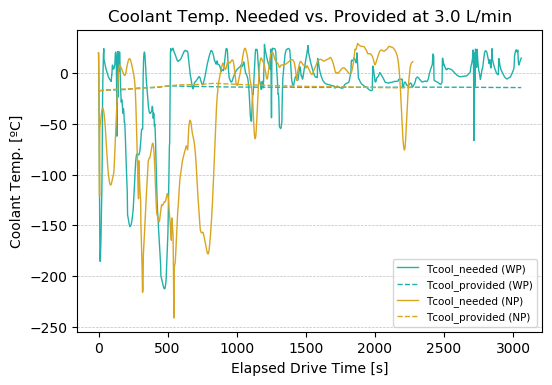

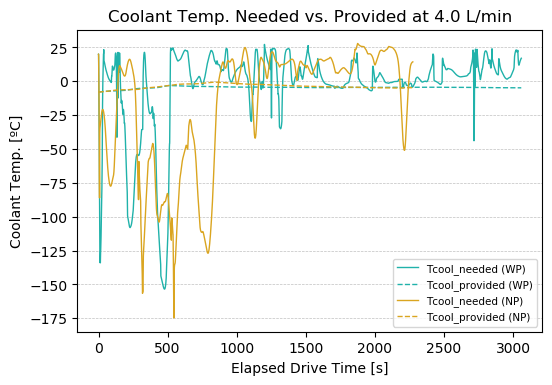

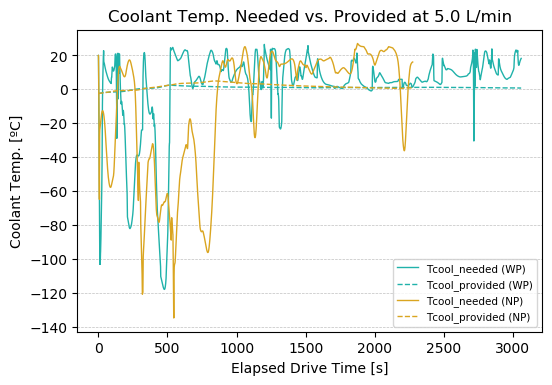

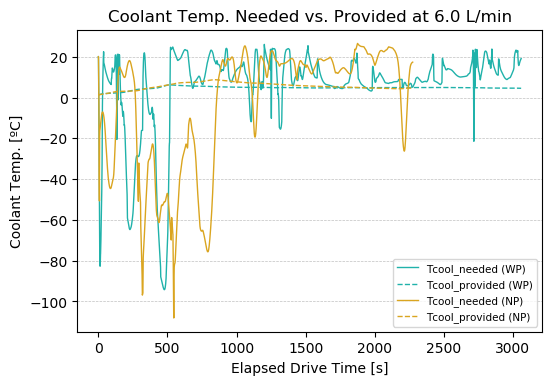

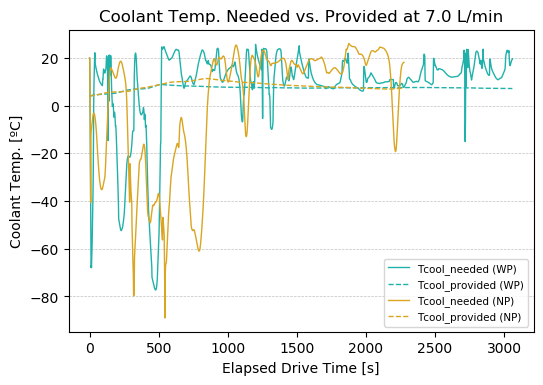

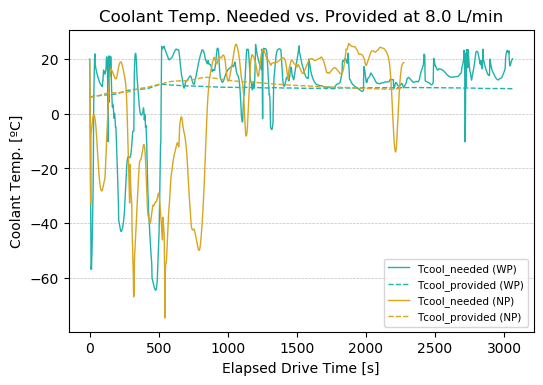

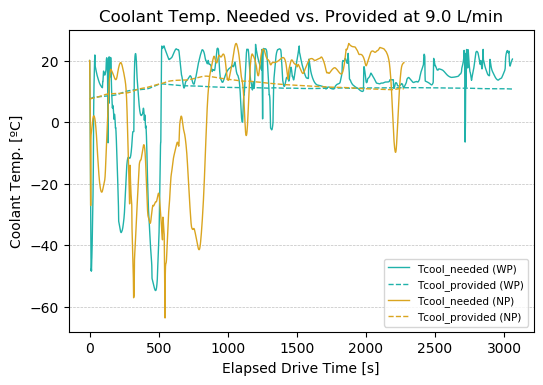

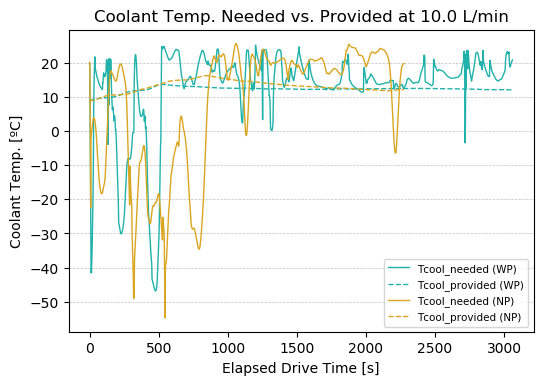

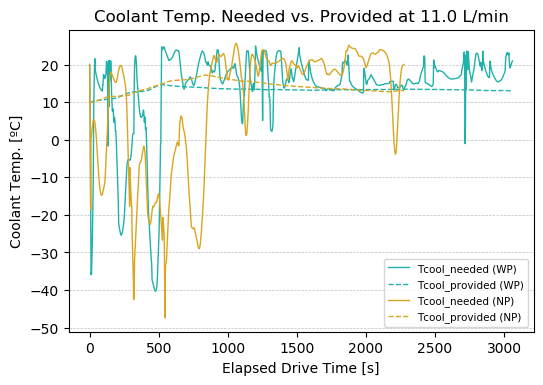

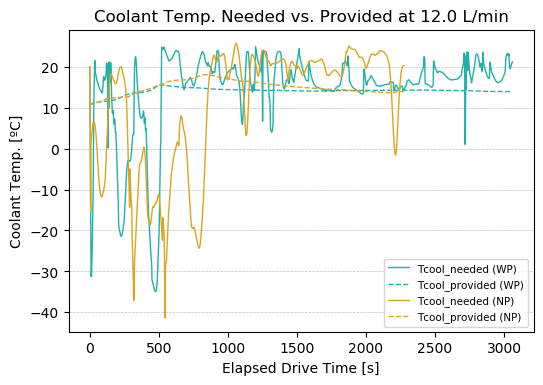

In [11]:
VFR_range=np.linspace(3,12,10)
chiller_capacity=7000
plotter2(VFR_range,chiller_capacity)

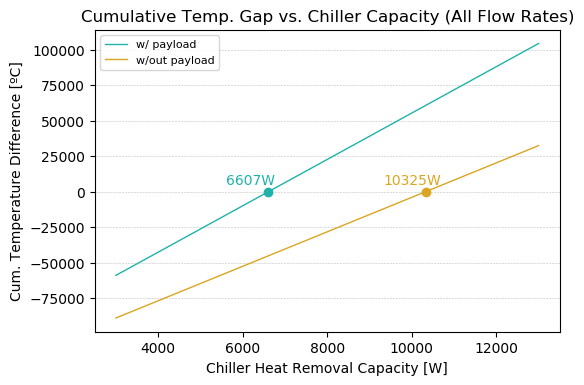

In [12]:
VFR=3 # temp gap is same across all flow rates, so we'll use 3 L/min
chiller_options=[3000,5000,7000,9000,11000,13000]
plotter3(VFR,chiller_options) 

In [13]:
# Unused in present analysis. May be used later to examine relationship between parameters.
def getMax(params): # finds and stores max value for each individual drive cycle for each parameter
    maxVals = [] # 1x5 list, each elem reflects one parameter and is a 1x4 
                 # list of the max values for each of the different drive cycles
    for i in range(len(params)):
        maxVals_i = [] # 1x4 list of the max values for each drive cycle for ONE parameter
        maxVals.append([max(params[i][0]),max(params[i][1]),max(params[i][2]),max(params[i][3])])
    return maxVals

def doRegression(VFR,chiller_capacity,loadCase):
    
    if loadCase == "WP":
        label1 = "(w/ payload)"
        col = 'lightseagreen' #colour for WP plots
    elif loadCase == "NP":
        label1 = "(w/out payload)"
        col = 'goldenrod' #colour for NP plots

    params = getParams(VFR,chiller_capacity,loadCase) # [1x5 of [1x4 of [1x~4000]]]
    maxParams = getMax(params)
    
    maxQgen_batt = maxParams[1]
    
    T_init = [5,15,25,35] # Ambient temperatures of drive cycles
    
    regress=stats.linregress(T_init,maxQgen_batt)
    plt.scatter(T_init,maxQgen_batt,color=col,marker='x')
    
    yy = []
    for i in range(len(xpoints)):
        yy.append(regress.slope*xpoints[i] + regress.intercept)
        
    R_sq= regress.rvalue**2
    slope = regress.slope
    intercept = regress.intercept
    
    plt.plot(xpoints,yy,colour=col,linewidth=0.8,label=loadCase)
    plt.xlabel('Drive Cycle Ambient Temperature [ºC]')
    plt.ylabel('Max. Battery Heat Generation [W]')
    plt.legend()
    
    plt.annotate("R^2 = {:.2f}".format(R_sq),(xpoints[2],yy[2]*1.01),color=col)
    
    print('R^2_%s : %.2f' %(loadCase,R_sq))  
    print('slope_%s : %.2f' %(loadCase,slope))
    print('intercept_%s : %.2f\n' %(loadCase,intercept))